In [137]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import brier_score


In [140]:
df = pd.read_excel('../data/complete_df.xlsx')

In [141]:
df.head()

,classe_name,patient_num,Gender,Age_at_disease,Local_relapse,Distant_relapse,Death,Date_of_lost_of_FU,survival_time,local_relapse_time,...,original_glszm_SmallAreaHighGrayLevelEmphasis_TARD,original_glszm_SmallAreaLowGrayLevelEmphasis_TARD,original_glszm_ZoneEntropy_TARD,original_glszm_ZonePercentage_TARD,original_glszm_ZoneVariance_TARD,original_ngtdm_Busyness_TARD,original_ngtdm_Coarseness_TARD,original_ngtdm_Complexity_TARD,original_ngtdm_Contrast_TARD,original_ngtdm_Strength_TARD
0,0,10,1,62.0,0,0,1,NaT,134.0,NaN,...,33.413109,0.009836,6.090384,0.166814,87.980503,1.770498,0.003704,39.277987,0.015188,0.332041
1,0,11,0,57.0,0,0,0,2017-06-08,NaN,NaN,...,712.327011,0.007341,6.313498,0.841126,0.268177,0.163645,0.004702,11442.875990,0.449753,9.512513
2,0,12,1,58.0,0,1,1,NaT,1870.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,13,1,65.0,0,1,1,NaT,2148.0,NaN,...,11.427517,0.035033,5.902304,0.066641,2534.900063,29.486908,0.000621,13.679928,0.009523,0.023968
4,0,14,1,64.0,0,0,1,NaT,152.0,NaN,...,2.908817,0.138365,4.091810,0.059633,762.292899,7.167425,0.011379,1.508313,0.013621,0.061704


In [142]:
df.head()

,classe_name,patient_num,Gender,Age_at_disease,Local_relapse,Distant_relapse,Death,Date_of_lost_of_FU,survival_time,local_relapse_time,...,original_glszm_SmallAreaHighGrayLevelEmphasis_TARD,original_glszm_SmallAreaLowGrayLevelEmphasis_TARD,original_glszm_ZoneEntropy_TARD,original_glszm_ZonePercentage_TARD,original_glszm_ZoneVariance_TARD,original_ngtdm_Busyness_TARD,original_ngtdm_Coarseness_TARD,original_ngtdm_Complexity_TARD,original_ngtdm_Contrast_TARD,original_ngtdm_Strength_TARD
0,0,10,1,62.0,0,0,1,NaT,134.0,NaN,...,33.413109,0.009836,6.090384,0.166814,87.980503,1.770498,0.003704,39.277987,0.015188,0.332041
1,0,11,0,57.0,0,0,0,2017-06-08,NaN,NaN,...,712.327011,0.007341,6.313498,0.841126,0.268177,0.163645,0.004702,11442.875990,0.449753,9.512513
2,0,12,1,58.0,0,1,1,NaT,1870.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,13,1,65.0,0,1,1,NaT,2148.0,NaN,...,11.427517,0.035033,5.902304,0.066641,2534.900063,29.486908,0.000621,13.679928,0.009523,0.023968
4,0,14,1,64.0,0,0,1,NaT,152.0,NaN,...,2.908817,0.138365,4.091810,0.059633,762.292899,7.167425,0.011379,1.508313,0.013621,0.061704


In [143]:
X = df.drop(['Death', 'Date_of_lost_of_FU', 'classe_name', 'Local_relapse', 'Distant_relapse', 'patient_num', 'survival_time', 'local_relapse_time', 'distant_relapse_time', 'censorship_time'], axis=1)
df['Death'] = df['Death'].astype(bool)
df['survival_time'] = df['survival_time'].astype(float)
y_death = df['Death']
df['y'] = df['censorship_time'].fillna(df['survival_time'])
df['y'] = df['y'].fillna(df['y'].max(), downcast='infer', )

Y_death = list(zip(df['Death'], df['y']))

# Define the structured data type
dtype = np.dtype([('cens', '?'), ('time', '<f8')])

# Convert the list of tuples into a NumPy structured array
Y_death = np.array(Y_death, dtype=dtype)


/var/folders/wr/2dl0dqn97f75msdgk9cvcp2m0000gn/T/ipykernel_34644/5035005.py:6: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  df['y'] = df['y'].fillna(df['y'].max(), downcast='infer', )


In [144]:
imputer = IterativeImputer(random_state=100, max_iter=10)
imputer.fit(X)
X_imputed = imputer.transform(X)

In [145]:
selector = SelectKBest(f_classif, k=20) # k is the number of features to be selected
X_new = selector.fit_transform(X_imputed, y_death)

In [146]:
print('feature importance: ', selector.scores_)

feature importance:  [4.31849088e-01 9.56889744e-01 1.53161955e-01 1.95150514e-01
 5.64850011e-02 2.27299056e-01 6.31644317e-01 1.71719756e+00
 1.67101940e-02 2.16518025e-01 1.80195191e-01 1.25390429e-01
 1.50079238e+00 9.95865725e-02 4.72242305e-01 1.54251409e-01
 3.35262685e+00 5.64850011e-02 1.20095904e+00 1.95191060e-03
 1.25308938e+00 1.65648704e+00 2.62683204e+00 2.98219736e+00
 3.39488104e+00 3.77701605e+00 1.69309469e+00 2.86044242e+00
 1.27822828e+00 3.16693394e+00 1.42202465e+00 1.53323148e+00
 1.44487150e+00 1.26858578e+00 8.40609821e-01 1.16906289e+00
 2.38014362e+00 3.48141474e-05 6.84281027e-02 1.25333205e+00
 5.04115626e-01 4.96766984e-01 2.00881948e-01 1.17500306e+00
 1.68327353e+00 1.40995359e+00 1.49228950e+00 4.23168719e-01
 6.19862502e-01 1.32378868e+00 8.19220922e-02 1.42578237e+00
 6.53574463e-01 1.58125557e+00 1.35138742e+00 7.06925125e-02
 1.39921057e-01 1.56299643e-03 3.33389488e-01 8.14895876e-01
 1.15298822e+00 4.28725745e+00 2.23955612e+00 2.25557757e-03
 8.

In [147]:

columns = X.columns
feature_scores = list(zip(selector.scores_,columns))
sorted_feature_scores = sorted(feature_scores,reverse=True)

num_list = []
col_list = []
for i in range(len(columns)):
   num_list.append((sorted_feature_scores[i])[0])
   col_list.append((sorted_feature_scores [i])[1])



([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'original_glszm_ZoneEntropy_ART'),
  Text(1, 0, 'original_glszm_ZoneEntropy_TARD'),
  Text(2, 0, 'original_glrlm_RunEntropy_TARD'),
  Text(3, 0, 'original_gldm_DependenceVariance_ART'),
  Text(4, 0, 'original_shape_Maximum2DDiameterRow_ART'),
  Text(5, 0, 'original_shape_Maximum2DDiameterColumn_ART'),
  Text(6, 0, 'original_firstorder_Skewness_ART'),
  Text(7, 0, 'original_gldm_LargeDependenceEmphasis_ART'),
  Text(8, 0, 'original_shape_MinorAxisLength_ART'),
  Text(9, 0, 'original_shape_MajorAxisLength_ART'),
  Text(10, 0, 'original_gldm_DependenceEntropy_TARD'),
  Text(11, 0, 'original_shape_Maximum3DDiameter_ART'),
  Text(12, 0, 'original_shape_LeastAxisLength_ART'),
  Text(13, 0, 'original_glcm_JointEnergy_TARD'),
  Text(14, 0, 'original_ngtdm_Busyness_TARD'),
  Text(15, 0, 'original_ngtdm_Busyness_VEIN'),
  Text(16, 0, 'original_shape_Maximum2DDiameterColumn_PORT'),
  Text(17, 0, 'original_glcm_C

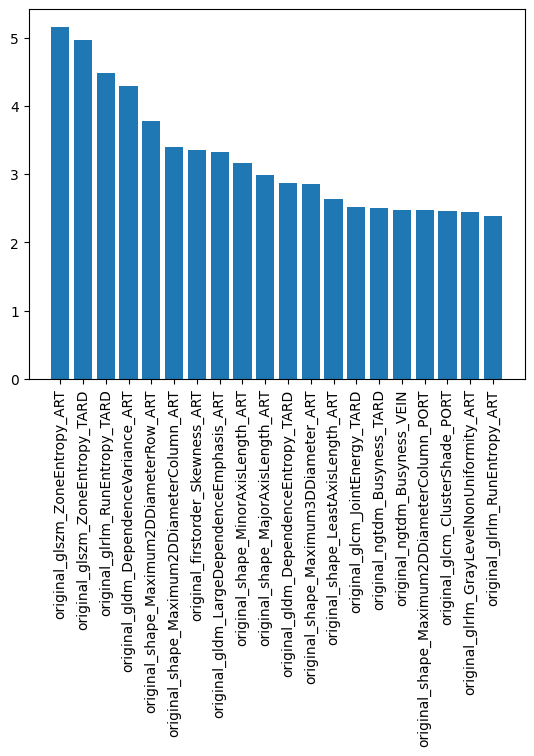

In [148]:


plt.bar(col_list[0:20],num_list[0:20])
plt.xticks(rotation=90)



In [149]:


scaler = StandardScaler()  

X_scaled = scaler.fit_transform(X_imputed)


In [150]:
X.isnull().sum()/len(X)*100

Gender                                  0.000000
Age_at_disease                          3.401361
original_firstorder_10Percentile_ART    3.401361
original_firstorder_90Percentile_ART    3.401361
original_firstorder_Energy_ART          3.401361
                                          ...   
original_ngtdm_Busyness_TARD            9.523810
original_ngtdm_Coarseness_TARD          9.523810
original_ngtdm_Complexity_TARD          9.523810
original_ngtdm_Contrast_TARD            9.523810
original_ngtdm_Strength_TARD            9.523810
Length: 430, dtype: float64

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y_death, test_size=0.25, random_state=20)

In [152]:
rsf = RandomSurvivalForest(
    n_estimators=1000, min_samples_split=10, min_samples_leaf=15, n_jobs=-1, random_state=20
)
rsf.fit(X_train, y_train)

RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10,
                     n_estimators=1000, n_jobs=-1, random_state=20)

In [153]:
surv_funcs = rsf.predict_survival_function(X_test)

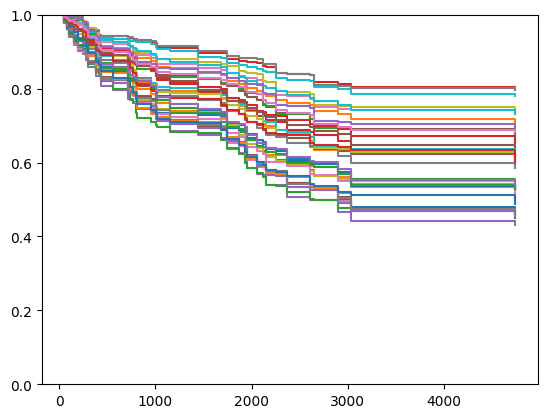

In [154]:
for fn in surv_funcs:
   plt.step(fn.x, fn(fn.x), where="post")


plt.ylim(0, 1)

plt.show()

In [157]:
preds = [fn(1825) for fn in surv_funcs]

In [158]:
times, score = brier_score(y_train, y_test, preds, 1825)

print(score)

[0.21459273]


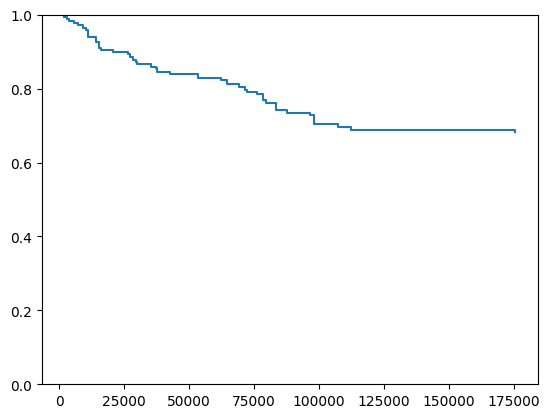

In [161]:
plt.step(sum(fn.x for fn in surv_funcs), fn(fn.x), where="post")


plt.ylim(0, 1)

plt.show()

In [160]:
sum(fn(1825) for fn in surv_funcs)

27.572492891714113